# STM Modelling 

In [202]:
import math
import numpy as np
import pandas as pd
from sklearn import linear_model
import random
from datetime import datetime
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [296]:
stations = pd.read_csv("./CSVFiles/stations.csv").drop(columns=["Unnamed: 0"])
stations.head()

max_cluster = [2, 3, 5, 7, 8, 9, 10, 27, 29, 30, 31, 32, 33, 36, 37, 38, 39, 40, 42]
min_cluster = [1, 4, 6, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 34]
cluster = max_cluster

cluster_training = []
cluster_validation = []
cluster_testing = []
while True:
    x = random.choice(cluster) 
    if len(cluster_training) < 12 and x not in cluster_training:
        cluster_training.append(x)
        cluster.remove(x)
    elif len(cluster_validation) < 4 and x not in cluster_validation:
        cluster_validation.append(x)
        cluster.remove(x)
    elif len(cluster_testing) < 3 and x not in cluster_testing:
        cluster_testing.append(x)
        cluster.remove(x)

    if len(cluster_training) == 12 and len(cluster_validation) == 4 and len(cluster_testing) == 3:
        break

print(f"Cluster Training: {cluster_training}")
print(f"Cluster Validation: {cluster_validation}")
print(f"Cluster Testing: {cluster_testing}")

Cluster Training: [5, 32, 27, 9, 40, 2, 29, 39, 31, 10, 3, 38]
Cluster Validation: [37, 33, 8, 42]
Cluster Testing: [36, 30, 7]


In [323]:
trips = pd.read_csv("./CSVFiles/tripsStationHour.csv").drop(columns=["Unnamed: 0"])

day = []
year = []
for trip in trips.values:
    date = datetime.strptime(trip[0], "%Y-%m-%d %H:%M:%S").timetuple()
    day.append(date.tm_yday)
    year.append(date.tm_year)

trips["Day"] = day
trips["Year"] = year
trips = trips.drop(columns=["DateEnd"])
trips_training = trips.loc[trips["StationEnd"].isin(cluster_training)]
trips_training.head()
trips_testing = trips.loc[trips["StationEnd"].isin(cluster_testing)]

## Regression

In [324]:
errors = {"Mean Absolute Error": [], "Mean Squared Error": [], "Mean Absolute Percentage Error": [], "Mean Percentage Error": []}

first_hour = trips_training.values[0][0]
first_day = trips_training.values[0][3]
first_year = trips_training.values[0][4]

accuracy = []

### Method 1
Input: c(t)

Output: c(t+1)

In [325]:
X = trips_training.drop(columns=["Count"])
y = trips_training["Count"]

lm = linear_model.LinearRegression().fit(X, y)

MAE = 0
MSE = 0
MAPE = 0
MPE = 0
for hour, station, count, day, year in trips_testing.values:
    prediction = lm.predict(np.array([[hour, station, day, year]]))
    MAE += abs(count - prediction)
    MSE += (count - prediction)**2
    MAPE += (abs((count - prediction))/count)
    MPE += ((count - prediction)/count)
MAE = MAE / len(trips_training)
MSE = MSE / len(trips_training)
MAPE = MAPE/len(trips_training)
MPE = MPE/len(trips_training)

errors["Mean Absolute Error"].append(MAE)
errors["Mean Squared Error"].append(MSE)
errors["Mean Absolute Percentage Error"].append(MAPE)
errors["Mean Percentage Error"].append(MPE)

accuracy.append(lm.score(trips_testing.drop(columns=["Count"]), trips_testing["Count"]))

MEAN ABSOLUTE ERROR
- 1.85703562 sem ano e dia
- 1.81389569 com ano e dia

MEAN SQUARE ERROR
- 6.31174683 sem ano e dia
- 6.050249 com ano e dia

### Method 2
Input: c(t), c(t-1)

Output: c(t+1)

In [350]:
count = 0
cnt_1day = []
for trip in trips_training.values:
    hour = trip[0]
    station = trip[1]
    day = trip[3]
    year = trip[4]

    if hour == first_hour and year == first_year and day == first_day:
        count += 1
        continue

    hour -= 1
    if hour == -1:
        hour = 23
        day -= 1

    df = trips_training.loc[(trips_training["Hour"] == hour) & (trips_training["Day"] == day) & (trips_training["Year"] == year) & (trips_training["StationEnd"] == station)]

    if df.empty:
        cnt_1day.append(0)
    else:
        cnt_1day.append(df.values[0][2])

count = 0
cnt_1day = []
for trip in trips_testing.values:
    hour = trip[0]
    station = trip[1]
    day = trip[3]
    year = trip[4]

    if hour == first_hour and year == first_year and day == first_day:
        count += 1
        continue

    hour -= 1
    if hour == -1:
        hour = 23
        day -= 1

    df = trips_testing.loc[(trips_testing["Hour"] == hour) & (trips_testing["Day"] == day) & (trips_testing["Year"] == year) & (trips_testing["StationEnd"] == station)]

    if df.empty:
        cnt_1day.append(0)
    else:
        cnt_1day.append(df.values[0][2])

trips_method2 = trips_training[count:].copy()
trips_method2["Count1"] = cnt_1day
trips_testing1 = trips_testing[count:].copy()
trips_testing1["Count1"] = cnt_1day

X = trips_method2.drop(columns=["Count"])
y = trips_method2["Count"]

lm = linear_model.LinearRegression().fit(X, y)

MAE = 0
MSE = 0
MAPE = 0
MPE = 0
for hour, station, count, day, year, count_1 in trips_testing1.values:
    prediction = lm.predict(np.array([[hour, station, day, year, count_1]]))
    MAE += abs(count - prediction)
    MSE += (count - prediction)**2
    MAPE += (abs((count - prediction))/count)
    MPE += ((count - prediction)/count)

MAE = MAE / len(trips_method2)
MSE = MSE / len(trips_method2)
MAPE = MAPE / len(trips_method2)
MPE = MPE / len(trips_method2)

errors["Mean Absolute Error"].append(MAE)
errors["Mean Squared Error"].append(MSE)
errors["Mean Absolute Percentage Error"].append(MAPE)
errors["Mean Percentage Error"].append(MPE)

accuracy.append(lm.score(trips_testing1.drop(columns=["Count"]), trips_testing1["Count"]))

,Hour,StationEnd,Count,Day,Year,Count1
17,1,38,3,1,2011,2
18,1,39,2,1,2011,1
19,1,29,5,1,2011,1
23,1,32,3,1,2011,0
25,1,10,1,1,2011,0


In [ ]:
count_1 = []
for trip in trips_training.values:
    hour = trip[0]
    station = trip[1]
    day = trip[3]
    year = trip[4]

    if hour == first_hour and year == first_year and day == first_day:
        count_1.append(0)
        continue

    hour -= 1
    if hour == -1:
        hour = 23
        day -= 1

    df = trips_training.loc[(trips_training["Hour"] == hour) & (trips_training["Day"] == day) & (trips_training["Year"] == year) & (trips_training["StationEnd"] == station)]

    if df.empty:
        count_1.append(0)
    else:
        count_1.append(df.values[0][2])

trips_method2 = trips_training.copy()
trips_method2["Count1"] = count_1
trips_method2.head()

In [301]:
count_1 = []
for trip in trips_testing.values:
    hour = trip[0]
    station = trip[1]
    day = trip[3]
    year = trip[4]

    if hour == first_hour and year == first_year and day == first_day:
        count_1.append(0)
        continue

    hour -= 1
    if hour == -1:
        hour = 23
        day -= 1

    df = trips_training.loc[(trips_training["Hour"] == hour) & (trips_training["Day"] == day) & (trips_training["Year"] == year) & (trips_training["StationEnd"] == station)]

    if df.empty:
        count_1.append(0)
    else:
        count_1.append(df.values[0][2])

trips_testing["Count1"] = count_1

In [302]:
X = trips_method2.drop(columns=["Count"])
y = trips_training["Count"]

lm = linear_model.LinearRegression().fit(X, y)

MAE = 0
MSE = 0
MAPE = 0
MPE = 0
for hour, station, count, day, year, count_1 in trips_testing.values:
    prediction = lm.predict(np.array([[hour, station, day, year, count_1]]))
    MAE += abs(count - prediction)
    MSE += (count - prediction)**2
    MAPE += (abs((count - prediction))/count)
    MPE += ((count - prediction)/count)
MAE = MAE / len(trips_method2)
MSE = MSE / len(trips_method2)
MAPE = MAPE/len(trips_method2)
MPE = MPE/len(trips_method2)

errors["Mean Absolute Error"].append(MAE)
errors["Mean Squared Error"].append(MSE)
errors["Mean Absolute Percentage Error"].append(MAPE)
errors["Mean Percentage Error"].append(MPE)

accuracy.append(lm.score(trips_testing.drop(columns=["Count"]), trips_testing["Count"]))

MEAN ABSOLUTE ERROR
- 1.567411 sem ano e dia
- 1.55520812 com ano e dia

MEAN SQUARE ERROR
- 4.71078126 sem ano e dia
- 4.65251971 com ano e dia

### Method 3

Input: c(t), c(t-1), c(t-1semana)

Output: c(t+1)

In [303]:
count_1week = []
for trip in trips_training.values:
    hour = trip[0]
    station = trip[1]
    day = trip[3]
    year = trip[4]

    if day < first_day + 7:
        count_1week.append(0)
        continue

    day -= 7

    df = trips_training.loc[(trips_training["Hour"] == hour) & (trips_training["Day"] == day) & (trips_training["Year"] == year) & (trips_training["StationEnd"] == station)]

    if df.empty:
        count_1week.append(0)
    else:
        count_1week.append(df.values[0][2])

trips_method3 = trips_method2
trips_method3["Count1week"] = count_1week

In [304]:
count_1week = []
for trip in trips_testing.values:
    hour = trip[0]
    station = trip[1]
    day = trip[3]
    year = trip[4]

    if day < first_day + 7:
        count_1week.append(0)
        continue

    day -= 7

    df = trips_training.loc[(trips_training["Hour"] == hour) & (trips_training["Day"] == day) & (trips_training["Year"] == year) & (trips_training["StationEnd"] == station)]

    if df.empty:
        count_1week.append(0)
    else:
        count_1week.append(df.values[0][2])

trips_testing["Count1week"] = count_1week

In [305]:
X = trips_method3.drop(columns=["Count"])
y = trips_training["Count"]

lm = linear_model.LinearRegression().fit(X, y)

MAE = 0
MSE = 0
MAPE = 0
MPE = 0
for hour, station, count, day, year, count_1, count_1sem in trips_testing.values:
    prediction = lm.predict(np.array([[hour, station, day, year, count_1, count_1sem]]))
    MAE += abs(count - prediction)
    MSE += (count - prediction)**2
    MAPE += (abs((count - prediction))/count)
    MPE += ((count - prediction)/count)
MAE = MAE / len(trips_method3)
MSE = MSE / len(trips_method3)
MAPE = MAPE/len(trips_method3)
MPE = MPE/len(trips_method3)

errors["Mean Absolute Error"].append(MAE)
errors["Mean Squared Error"].append(MSE)
errors["Mean Absolute Percentage Error"].append(MAPE)
errors["Mean Percentage Error"].append(MPE)

accuracy.append(lm.score(trips_testing.drop(columns=["Count"]), trips_testing["Count"]))

MEAN ABSOLUTE ERROR
- 1.42252798 sem ano e dia
- 1.42047963 com ano e dia

MEAN SQUARE ERROR
- 3.92892851 sem ano e dia
- 3.91436452 com ano e dia

### Method 4

Input: c(t), c(t-1), c(t-1semana), c(t-2semana)

Output: c(t+1)

In [306]:
count_2week = []
for trip in trips_training.values:
    hour = trip[0]
    station = trip[1]
    day = trip[3]
    year = trip[4]

    if day < first_day + 14:
        count_2week.append(0)
        continue

    day -= 7

    df = trips_training.loc[(trips_training["Hour"] == hour) & (trips_training["Day"] == day) & (trips_training["Year"] == year) & (trips_training["StationEnd"] == station)]

    if df.empty:
        count_2week.append(0)
    else:
        count_2week.append(df.values[0][2])

trips_method4 = trips_method3
trips_method4["Count2week"] = count_2week

In [307]:
count_2week = []
for trip in trips_testing.values:
    hour = trip[0]
    station = trip[1]
    day = trip[3]
    year = trip[4]

    if day < first_day + 14:
        count_2week.append(0)
        continue

    day -= 7

    df = trips_training.loc[(trips_training["Hour"] == hour) & (trips_training["Day"] == day) & (trips_training["Year"] == year) & (trips_training["StationEnd"] == station)]

    if df.empty:
        count_2week.append(0)
    else:
        count_2week.append(df.values[0][2])

trips_testing["Count2week"] = count_2week

In [308]:
X = trips_method4.drop(columns=["Count"])
y = trips_training["Count"]

lm = linear_model.LinearRegression().fit(X, y)

MAE = 0
MSE = 0
MAPE = 0
MPE = 0
for hour, station, count, day, year, count_1, count_1sem, count_2sem in trips_testing.values:
    prediction = lm.predict(np.array([[hour, station, day, year, count_1, count_1sem, count_2sem]]))
    MAE += abs(count - prediction)
    MSE += (count - prediction)**2
    MAPE += (abs((count - prediction))/count)
    MPE += ((count - prediction)/count)
MAE = MAE / len(trips_method4)
MSE = MSE / len(trips_method4)
MAPE = MAPE/len(trips_method4)
MPE = MPE/len(trips_method4)

errors["Mean Absolute Error"].append(MAE)
errors["Mean Squared Error"].append(MSE)
errors["Mean Absolute Percentage Error"].append(MAPE)
errors["Mean Percentage Error"].append(MPE)

accuracy.append(lm.score(trips_testing.drop(columns=["Count"]), trips_testing["Count"]))

MEAN ABSOLUTE ERROR
- 1.42235206 sem ano e dia
- 1.42030539 com ano e dia

MEAN SQUARE ERROR
- 3.92778711 sem ano e dia
- 3.91301564 com ano e dia

### Method 5

Input: c(t), c(t-1), c(t-1semana), c(t-2semana), c(t-3semana)

Output: c(t+1)

In [309]:
count_3week = []
for trip in trips_training.values:
    hour = trip[0]
    station = trip[1]
    day = trip[3]
    year = trip[4]

    if day < first_day + 21:
        count_3week.append(0)
        continue

    day -= 7

    df = trips_training.loc[(trips_training["Hour"] == hour) & (trips_training["Day"] == day) & (trips_training["Year"] == year) & (trips_training["StationEnd"] == station)]

    if df.empty:
        count_3week.append(0)
    else:
        count_3week.append(df.values[0][2])

trips_method5 = trips_method4
trips_method5["Count3week"] = count_3week

In [310]:
count_3week = []
for trip in trips_testing.values:
    hour = trip[0]
    station = trip[1]
    day = trip[3]
    year = trip[4]

    if day < first_day + 21:
        count_3week.append(0)
        continue

    day -= 7

    df = trips_training.loc[(trips_training["Hour"] == hour) & (trips_training["Day"] == day) & (trips_training["Year"] == year) & (trips_training["StationEnd"] == station)]

    if df.empty:
        count_3week.append(0)
    else:
        count_3week.append(df.values[0][2])

trips_testing["Count3week"] = count_3week

In [311]:
X = trips_method5.drop(columns=["Count"])
y = trips_training["Count"]

lm = linear_model.LinearRegression().fit(X, y)

MAE = 0
MSE = 0
MAPE = 0
MPE = 0
for hour, station, count, day, year, count_1, count_1sem, count_2sem, count_3sem in trips_testing.values:
    prediction = lm.predict(np.array([[hour, station, day, year, count_1, count_1sem, count_2sem, count_3sem]]))
    MAE += abs(count - prediction)
    MSE += (count - prediction)**2
    MAPE += (abs((count - prediction))/count)
    MPE += ((count - prediction)/count)
MAE = MAE / len(trips_method5)
MSE = MSE / len(trips_method5)
MAPE = MAPE/len(trips_method5)
MPE = MPE/len(trips_method5)

errors["Mean Absolute Error"].append(MAE)
errors["Mean Squared Error"].append(MSE)
errors["Mean Absolute Percentage Error"].append(MAPE)
errors["Mean Percentage Error"].append(MPE)

accuracy.append(lm.score(trips_testing.drop(columns=["Count"]), trips_testing["Count"]))

MEAN ABSOLUTE ERROR
- 1.42208032 sem ano e dia
- 1.4200121 com ano e dia

MEAN SQUARE ERROR
- 3.92650488 sem ano e dia
- 3.91142526 com ano e dia

### Method 6

Input: c(t), c(t-1), c(t-1semana), c(t-2semana), c(t-3semana), c(t-4semana)

Output: c(t+1)

In [312]:
count_4week = []
for trip in trips_training.values:
    hour = trip[0]
    station = trip[1]
    day = trip[3]
    year = trip[4]

    if day < first_day + 21:
        count_4week.append(0)
        continue

    day -= 7

    df = trips_training.loc[(trips_training["Hour"] == hour) & (trips_training["Day"] == day) & (trips_training["Year"] == year) & (trips_training["StationEnd"] == station)]

    if df.empty:
        count_4week.append(0)
    else:
        count_4week.append(df.values[0][2])

trips_method6 = trips_method5
trips_method6["Count4week"] = count_4week

In [313]:
count_4week = []
for trip in trips_testing.values:
    hour = trip[0]
    station = trip[1]
    day = trip[3]
    year = trip[4]

    if day < first_day + 21:
        count_4week.append(0)
        continue

    day -= 7

    df = trips_training.loc[(trips_training["Hour"] == hour) & (trips_training["Day"] == day) & (trips_training["Year"] == year) & (trips_training["StationEnd"] == station)]

    if df.empty:
        count_4week.append(0)
    else:
        count_4week.append(df.values[0][2])

trips_testing["Count4week"] = count_4week

In [314]:
X = trips_method6.drop(columns=["Count"])
y = trips_training["Count"]

lm = linear_model.LinearRegression().fit(X, y)

MAE = 0
MSE = 0
MAPE = 0
MPE = 0
for hour, station, count, day, year, count_1, count_1sem, count_2sem, count_3sem, count_4sem in trips_testing.values:
    prediction = lm.predict(np.array([[hour, station, day, year, count_1, count_1sem, count_2sem, count_3sem, count_4sem]]))
    MAE += abs(count - prediction)
    MSE += (count - prediction)**2
    MAPE += (abs((count - prediction))/count)
    MPE += ((count - prediction)/count)
MAE = MAE / len(trips_method6)
MSE = MSE / len(trips_method6)
MAPE = MAPE/len(trips_method6)
MPE = MPE/len(trips_method6)

errors["Mean Absolute Error"].append(MAE)
errors["Mean Squared Error"].append(MSE)
errors["Mean Absolute Percentage Error"].append(MAPE)
errors["Mean Percentage Error"].append(MPE)

accuracy.append(lm.score(trips_testing.drop(columns=["Count"]), trips_testing["Count"]))

MEAN ABSOLUTE ERROR
- 1.42208032 sem ano e dia
- 1.4200121 com ano e dia

MEAN SQUARE ERROR
- 3.92650488 sem ano e dia
- 3.91142526 com ano e dia

### Graphs

Text(0.5, 0, 'Methods')

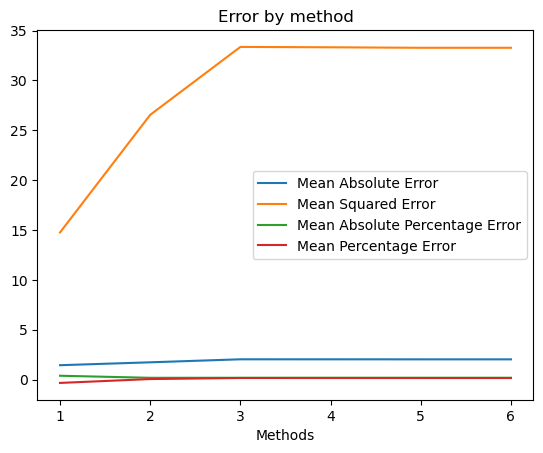

In [315]:
legend = []
for errorType, error in errors.items():
    plt.plot(list(range(1,len(error)+1)), error)
    legend.append(f"{errorType}")
plt.legend(legend)
plt.title("Error by method")
plt.xlabel("Methods")

Text(0.5, 0, 'Methods')

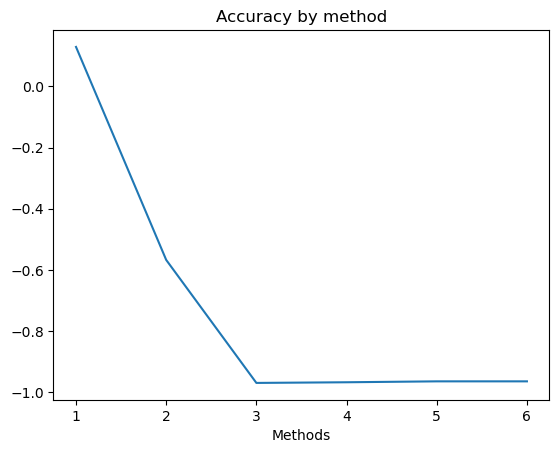

In [316]:
plt.plot(list(range(1,len(accuracy)+1)), accuracy)
plt.title("Accuracy by method")
plt.xlabel("Methods")